# This notebook reconstructs alternative buffers to create additional data
Ethnologue data cannot be shared freely due to copyright issues. Therefore you can only view the output of the cells.

# Setup

In [ ]:
import sys, os, time
import matplotlib.pyplot as plt

# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

# GIS packages
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Polygon, Point
import pyproj
import georasters as gr
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

# Various other packages
import isounidecode         # Decode and encode text
import itertools
from functools import reduce

# Paths
proot = '/work/Replication_Dickens_2022/data/'
pathout = proot + 'Ethnologue/'
pathstats = proot + 'stats/'
pathethno = '' # Since the Ethnologed is protected under copy rights we can't upload the dataset.

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/users/ozak/micromamb

In [3]:
#%%px --local
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [4]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

# Using Original Data
## Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

Main original replication data file with all pairwise data based on buffers of 50kms

In [5]:
dfor = pd.read_stata(proot + 'EJ_Dickens_Border_100km.dta')
dfor

/tmp/ipykernel_3341423/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
1,AAA-NGA-OKE-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Okpe,oke,Nigeria,Niger-Congo,0.628569,...,oke,aaa,oke,GHOTUO,OKPE,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
2,AAB-NGA-JID-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Bu,jid,Nigeria,Niger-Congo,0.833333,...,jid,aab,jid,TESU,BU_NIGERIA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
3,AAB-NGA-RIN-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Nungu,rin,Nigeria,Niger-Congo,NaN,...,rin,aab,rin,TESU,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
4,AAB-NGA-TDV-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Toro,tdv,Nigeria,Niger-Congo,0.532142,...,tdv,aab,tdv,TESU,TORO,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,ZYN-CHN-YUE-CHN,"Zhuang, Yongnan",zyn,China,Tai-Kadai,"Chinese, Yue",yue,China,Sino-Tibetan,0.813015,...,yue,zyn,yue,NINGMING_YONGNAN_ZHUANG,CANTONESE,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15599,ZZJ-CHN-CMN-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,"Chinese, Mandarin",cmn,China,Sino-Tibetan,0.865388,...,cmn,zzj,cmn,LONGZHOU_ZHUANG,KUNMING_MANDARIN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15600,ZZJ-CHN-IUM-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Iu Mien,ium,China,Hmong-Mien,0.844456,...,ium,zzj,ium,LONGZHOU_ZHUANG,CHIANGRAI_MIEN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Hmong-Mien,Mienic,Mian-Jin",156.0,156.0,Asia
15601,ZZJ-CHN-TYZ-VNM,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Tay,tyz,Vietnam,Tai-Kadai,0.528902,...,tyz,zzj,tyz,LONGZHOU_ZHUANG,TAY,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central",156.0,704.0,Asia


In [6]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [7]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [8]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa


In [9]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


# New Data
## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
###  Import data

In [10]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno['key'] = 0
ethno.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,137000000,137000000.0,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,1,"MULTIPOLYGON (((34.30387 61.85888, 34.34665 61..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,225000000,225000000.0,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,1,"MULTIPOLYGON (((-122.52301 47.78182, -122.5395..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,187000000,187000000.0,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,1,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,15600000,15600000.0,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,1,"MULTIPOLYGON (((142.52003 -10.70436, 142.52347..."
4,ENG-CAN,eng-CAN,eng-ca,eng-CA,English,English,ENGLISH,English,Americas,Canada,19400000,19400000.0,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Canada,eng,1,"MULTIPOLYGON (((-74.13254 45.52187, -74.11124 ..."


In [11]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [12]:
ethno.shape

(7388, 20)

## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
Find duplicated languages x country. Unlike v16, v17 has a duplicated language

In [13]:
ethno.loc[ethno.duplicated('ID')]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
4886,ALN-SRB,aln-SRB,aln-rs,aln-RI,Gheg Albanian,"Albanian, Gheg","ALBANIAN, GHEG","Albanian, Gheg",Europe,Serbia,1630000,1630000.0,"Indo-European, Albanian, Gheg",L,Indo-European,INDO-EUROPEAN,Serbia,aln,2,"POLYGON ((21.43371 42.77874, 21.43528 42.81889..."


In [14]:
ethno.loc[ethno['ID']=='ALN-SRB'].area

/tmp/ipykernel_3341423/4208167519.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ethno.loc[ethno['ID']=='ALN-SRB'].area


4452    0.036987
4886    0.026126
dtype: float64

<AxesSubplot:>

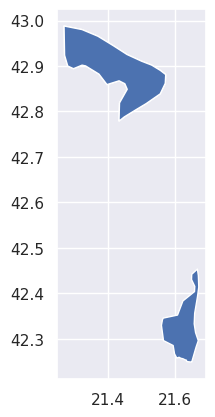

In [15]:
ethno.loc[ethno['ID']=='ALN-SRB'].plot()

So ALN-SRB is the only one creating duplicates.

Let's create the union of these two so there is only 1 so we can replace it for the aggregate of the 2 rows.

In [16]:
alnsrb = ethno.loc[ethno.ID=='ALN-SRB'].reset_index(drop=True)
alnsrb

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
0,ALN-SRB,aln-SRB,aln-rs,aln-RI,Gheg Albanian,"Albanian, Gheg","ALBANIAN, GHEG","Albanian, Gheg",Europe,Serbia,1630000,1630000.0,"Indo-European, Albanian, Gheg",L,Indo-European,INDO-EUROPEAN,Serbia,aln,2,"MULTIPOLYGON (((21.66390 42.28131, 21.65221 42..."
1,ALN-SRB,aln-SRB,aln-rs,aln-RI,Gheg Albanian,"Albanian, Gheg","ALBANIAN, GHEG","Albanian, Gheg",Europe,Serbia,1630000,1630000.0,"Indo-European, Albanian, Gheg",L,Indo-European,INDO-EUROPEAN,Serbia,aln,2,"POLYGON ((21.43371 42.77874, 21.43528 42.81889..."


In [17]:
ethno.loc[ethno.ID=='ALN-SRB', 'geometry'] = alnsrb.dissolve(by='ID').geometry.values[0]

In [18]:
ethno.loc[ethno.ID=='ALN-SRB']

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
4452,ALN-SRB,aln-SRB,aln-rs,aln-RI,Gheg Albanian,"Albanian, Gheg","ALBANIAN, GHEG","Albanian, Gheg",Europe,Serbia,1630000,1630000.0,"Indo-European, Albanian, Gheg",L,Indo-European,INDO-EUROPEAN,Serbia,aln,2,"MULTIPOLYGON (((21.65221 42.25165, 21.65133 42..."
4886,ALN-SRB,aln-SRB,aln-rs,aln-RI,Gheg Albanian,"Albanian, Gheg","ALBANIAN, GHEG","Albanian, Gheg",Europe,Serbia,1630000,1630000.0,"Indo-European, Albanian, Gheg",L,Indo-European,INDO-EUROPEAN,Serbia,aln,2,"MULTIPOLYGON (((21.65221 42.25165, 21.65133 42..."


In [19]:
ethno = ethno.drop_duplicates(subset=['ID']).reset_index(drop=True)

This is an example of what Dickens calls groups that occupy non-adjacent regions of a country (fn7).

No technical reasons to drop them, so we can include them.

Most of these are small, so not clear this is an issue.

## Create all pairs of languages/countries

In [20]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()

import dask.dataframe as dd
from dask.distributed import Client, progress
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()
client

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38563 instead
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35271 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35271/status,
Dashboard: http://127.0.0.1:35271/status,Workers: 16
Total threads: 128,Total memory: 500.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40559,Workers: 16
Dashboard: http://127.0.0.1:35271/status,Total threads: 128
Started: Just now,Total memory: 500.00 GiB
Comm: tcp://127.0.0.1:40001,Total threads: 8
Dashboard: http://127.0.0.1:45213/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:43071,


In [21]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:6876: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [22]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 69.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:73: UserWarning: Geometry is in a geographic CRS. Res

In [23]:
pairs.shape

(75972, 40)

In [24]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [25]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2
423,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,India,5600000,5600000.0,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr,5


In [26]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

,ID_1,ID_2,ID,geometry_1,geometry_2
0,RUS-RUS,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
1,JPN-JPN,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((153.81556 24.15803, 153.80374 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ..."
3,CMN-CHN,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((80.58287 38.16474, 80.57683 38...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ..."
4,KHK-MNG,CMN-CHN,CMN-CHN,"POLYGON ((92.34331 48.19710, 92.35761 48.20942...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ..."


In [27]:
%%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 77.8 ms, sys: 13.3 ms, total: 91.1 ms
Wall time: 82.5 ms


(68585, 42)

In [28]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

,ID_1,ID_2,NAME2_1,NAME2_2
0,RUS-RUS,JPN-JPN,RUSSIAN,JAPANESE
1,RUS-RUS,CMN-CHN,RUSSIAN,"CHINESE, MANDARIN"
2,KHK-MNG,CMN-CHN,"MONGOLIAN, HALH","CHINESE, MANDARIN"
3,MVF-CHN,CMN-CHN,"MONGOLIAN, PERIPHERAL","CHINESE, MANDARIN"
4,KHG-CHN,CMN-CHN,"TIBETAN, KHAMS","CHINESE, MANDARIN"


We have dropped all same pair language/countries, now let's drop all same langauge pairs that are in differenct countries (e.g., SPA-MEX and SPA-GTM). Special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes. It's not clear there is a reason for different ISO code, so we also drop them

(see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

**This differs from Dickens, he seems to keep these**

In [29]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2,ID,geometry_2
531,SPA-MEX,spa-MEX,spa-mx,spa-MX,Spanish,Spanish,SPANISH,Spanish,Americas,Mexico,...,9000000.0,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Guatemala,spa,1,SPA-GTM,"MULTIPOLYGON (((-88.49902 15.89139, -88.44183 ..."


In [30]:
pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
#pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)
pairs.shape

(67221, 42)

In [32]:
%%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 20 s, sys: 219 ms, total: 20.2 s
Wall time: 19.7 s


In [33]:
non_repeated_pairs

,ID_1,ID_2
0,RUS-RUS,JPN-JPN
1,RUS-RUS,CMN-CHN
2,KHK-MNG,CMN-CHN
3,MVF-CHN,CMN-CHN
4,KHG-CHN,CMN-CHN
...,...,...
36669,DJE-BFA,HAU-BFA
36670,HAU-BFA,DJE-BFA
36671,AFN-NGA,NKX-NGA
36672,BHE-PAK,AEQ-PAK


In [34]:
a = pairs.loc[(pairs['ID_1']=='SPA-CHL') & (pairs['ID_2']=='ARN-ARG')].reset_index()
#a = pairs.loc[(pairs['ID_1']=='KHK-MNG') & (pairs['ID_2']=='CMN-CHN')].reset_index()
a.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1)

0    MULTILINESTRING ((-71.5553790344726 -43.093965...
dtype: object

In [35]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=100)

In [36]:
%%time
ddpairs['border'] = ddpairs.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1, meta=(None, 'geometry'))
#borders = ddpairs.compute(scheduler="threads", num_workers=120)
borders = ddpairs.compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 1.65 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 30.5 s, sys: 7.57 s, total: 38 s
Wall time: 36.7 s


In [37]:
borders[['ID_1', 'ID_2', 'geometry_1', 'geometry_2', 'border']]

,ID_1,ID_2,geometry_1,geometry_2,border
0,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...",MULTILINESTRING ((145.26184708531085 43.613034...
1,RUS-RUS,CMN-CHN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...",MULTILINESTRING ((124.36592265983182 53.027715...
2,KHK-MNG,CMN-CHN,"POLYGON ((92.34331 48.19710, 92.35761 48.20942...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...",LINESTRING (96.29691477755095 42.5289806328061...
3,MVF-CHN,CMN-CHN,"POLYGON ((97.30358 41.93900, 97.29472 41.94927...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...",MULTILINESTRING ((115.35494924338084 41.864068...
4,KHG-CHN,CMN-CHN,"POLYGON ((86.24880 31.02358, 86.25015 31.02981...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...",LINESTRING (102.2426301910543 29.7254765507846...
...,...,...,...,...,...
67216,NKX-NGA,AFN-NGA,"POLYGON ((7.61630 4.67900, 7.62824 4.66421, 7....","POLYGON ((7.46418 4.54514, 7.46363 4.54509, 7....",LINESTRING (7.4641768907509345 4.5451402848962...
67217,BHE-PAK,AEQ-PAK,"POLYGON ((69.46580 25.47820, 69.46580 25.47827...","POLYGON ((69.54476 25.17083, 69.54605 25.17116...",LINESTRING (69.5447627149274 25.17083470465792...
67218,AEQ-PAK,BHE-PAK,"POLYGON ((69.40962 25.31827, 69.42491 25.33095...","POLYGON ((69.48241 25.27896, 69.48404 25.27909...",LINESTRING (69.48240614882474 25.2789589298108...
67219,XNB-TWN,SXR-TWN,"POLYGON ((120.87169 23.52521, 120.88809 23.525...","POLYGON ((120.71130 23.26549, 120.71258 23.264...",LINESTRING (120.711301000341 23.26548799967150...


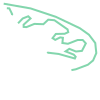

In [38]:
borders.loc[0, 'border']

In [39]:
borders_geo = gp.GeoDataFrame(borders, crs=ethno.crs, geometry='border')
borders_geo.head()

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2,ID,geometry_2,border
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,Japonic,L,Japonic,JAPONIC,Japan,jpn,1,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...","MULTILINESTRING ((145.26185 43.61303, 145.2890..."
1,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,CMN-CHN,"MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...","MULTILINESTRING ((124.36592 53.02772, 124.3888..."
2,KHK-MNG,khk-MNG,khk-mn,khk-MG,Halh Mongolian,"Mongolian, Halh","MONGOLIAN, HALH","Mongolian, Halh",Asia,Mongolia,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,CMN-CHN,"MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...","LINESTRING (96.29691 42.52898, 96.30858 42.544..."
3,MVF-CHN,mvf-CHN,mvf-cn,mvf-CH,Peripheral Mongolian,"Mongolian, Peripheral","MONGOLIAN, PERIPHERAL","Mongolian, Peripheral",Asia,China,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,CMN-CHN,"MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...","MULTILINESTRING ((115.35495 41.86407, 115.3246..."
4,KHG-CHN,khg-CHN,khg-cn,khg-CH,Khams Tibetan,"Tibetan, Khams","TIBETAN, KHAMS","Tibetan, Khams",Asia,China,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,CMN-CHN,"MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...","LINESTRING (102.24263 29.72548, 102.20450 29.7..."


In [40]:
borders_geo[borders_geo.columns.difference(['geometry_1', 'geometry_2'])].to_file(pathout + 'ethnologue_bordersv17.json', driver="GeoJSON")
#borders_geo.to_csv(pathout + 'ethnologue_bordersv16.csv', encoding='utf8', index=False)

## Overlap Datasets

Let's see overlap between both datasets and ways to merge

Create alternative IDs since we do not know order

In [41]:
borders_geo['identifier'] = borders_geo['ID_1'] + '-' + borders_geo['ID_2']
borders_geo['identifier']

0        RUS-RUS-JPN-JPN
1        RUS-RUS-CMN-CHN
2        KHK-MNG-CMN-CHN
3        MVF-CHN-CMN-CHN
4        KHG-CHN-CMN-CHN
              ...       
67216    NKX-NGA-AFN-NGA
67217    BHE-PAK-AEQ-PAK
67218    AEQ-PAK-BHE-PAK
67219    XNB-TWN-SXR-TWN
67220    SXR-TWN-XNB-TWN
Name: identifier, Length: 67221, dtype: object

In [42]:
dfor['ID_1'] = dfor['identifier'].apply(lambda x: x[:7])
dfor['ID_2'] = dfor['identifier'].apply(lambda x: x[8:])
dfor['ID_1alt'] = dfor['ID_2']
dfor['ID_2alt'] = dfor['ID_1']
dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']]

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
15598,ZYN-CHN,YUE-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
15599,ZZJ-CHN,CMN-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
15600,ZZJ-CHN,IUM-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
15601,ZZJ-CHN,TYZ-VNM,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


We check for non-repeated language-country pairs in original data

In [43]:
dfor.loc[dfor.duplicated('identifier')]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


In [44]:
dfor.loc[dfor.duplicated(subset=['ID_1', 'ID_2'])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


In [45]:
dfor.loc[dfor.duplicated(subset=['ID_1', 'ID_2'])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


## Merge

In [46]:
merge_iden = dfor[['identifier']].merge(borders_geo[['ID_1', 'ID_2', 'identifier']])
merge_iden

,identifier,ID_1,ID_2
0,AAA-NGA-EMA-NGA,AAA-NGA,EMA-NGA
1,AAB-NGA-JID-NGA,AAB-NGA,JID-NGA
2,AAB-NGA-RIN-NGA,AAB-NGA,RIN-NGA
3,AAB-NGA-TDV-NGA,AAB-NGA,TDV-NGA
4,AAC-PNG-DBY-PNG,AAC-PNG,DBY-PNG
...,...,...,...
13820,ZYN-CHN-YUE-CHN,ZYN-CHN,YUE-CHN
13821,ZZJ-CHN-CMN-CHN,ZZJ-CHN,CMN-CHN
13822,ZZJ-CHN-IUM-CHN,ZZJ-CHN,IUM-CHN
13823,ZZJ-CHN-TYZ-VNM,ZZJ-CHN,TYZ-VNM


In [47]:
merge1 = dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']])
merge1alt = dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], 
                                                             left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])
merged1 = pd.concat([merge1, merge1alt]).reset_index(drop=True)
merged1

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
2,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
3,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
4,AAC-PNG,DBY-PNG,DBY-PNG,AAC-PNG,AAC-PNG-DBY-PNG
...,...,...,...,...,...
27644,YUE-CHN,ZYN-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
27645,CMN-CHN,ZZJ-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
27646,IUM-CHN,ZZJ-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
27647,TYZ-VNM,ZZJ-CHN,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [48]:
merged1.loc[merged1.duplicated(subset=['identifier'])]

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
13825,EMA-NGA,AAA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
13826,JID-NGA,AAB-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
13827,RIN-NGA,AAB-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
13828,TDV-NGA,AAB-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
13829,DBY-PNG,AAC-PNG,DBY-PNG,AAC-PNG,AAC-PNG-DBY-PNG
...,...,...,...,...,...
27644,YUE-CHN,ZYN-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
27645,CMN-CHN,ZZJ-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
27646,IUM-CHN,ZZJ-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
27647,TYZ-VNM,ZZJ-CHN,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [49]:
dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], how='left')

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
15598,ZYN-CHN,YUE-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
15599,ZZJ-CHN,CMN-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
15600,ZZJ-CHN,IUM-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
15601,ZZJ-CHN,TYZ-VNM,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [50]:
dfor[['ID_1', 'ID_2', 'identifier']].merge(non_repeated_pairs[['ID_1', 'ID_2']])

,ID_1,ID_2,identifier
0,AAL-CMR,MXF-CMR,AAL-CMR-MXF-CMR
1,AAR-DJI,SOM-ETH,AAR-DJI-SOM-ETH
2,AAR-ETH,AMH-ETH,AAR-ETH-AMH-ETH
3,AAR-ETH,GAX-ETH,AAR-ETH-GAX-ETH
4,AAR-ETH,SOM-ETH,AAR-ETH-SOM-ETH
...,...,...,...
2599,ZYJ-CHN,ZGN-CHN,ZYJ-CHN-ZGN-CHN
2600,ZYJ-CHN,ZYB-CHN,ZYJ-CHN-ZYB-CHN
2601,ZYJ-CHN,ZZJ-CHN,ZYJ-CHN-ZZJ-CHN
2602,ZYN-CHN,CMN-CHN,ZYN-CHN-CMN-CHN


In [51]:
dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])

,ID_1alt,ID_2alt,identifier,ID_1,ID_2
0,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA,EMA-NGA,AAA-NGA
1,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA,JID-NGA,AAB-NGA
2,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA,RIN-NGA,AAB-NGA
3,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA,TDV-NGA,AAB-NGA
4,DBY-PNG,AAC-PNG,AAC-PNG-DBY-PNG,DBY-PNG,AAC-PNG
...,...,...,...,...,...
13819,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN,YUE-CHN,ZYN-CHN
13820,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN,CMN-CHN,ZZJ-CHN
13821,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN,IUM-CHN,ZZJ-CHN
13822,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM,TYZ-VNM,ZZJ-CHN


In [52]:
dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(non_repeated_pairs[['ID_1', 'ID_2']], left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])

,ID_1alt,ID_2alt,identifier,ID_1,ID_2
0,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA,EMA-NGA,AAA-NGA
1,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA,JID-NGA,AAB-NGA
2,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA,RIN-NGA,AAB-NGA
3,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA,TDV-NGA,AAB-NGA
4,DBY-PNG,AAC-PNG,AAC-PNG-DBY-PNG,DBY-PNG,AAC-PNG
...,...,...,...,...,...
12459,TYZ-VNM,ZYN-CHN,ZYN-CHN-TYZ-VNM,TYZ-VNM,ZYN-CHN
12460,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN,YUE-CHN,ZYN-CHN
12461,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN,CMN-CHN,ZZJ-CHN
12462,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN,IUM-CHN,ZZJ-CHN


In [53]:
%%time
non_repeated_pairs_or = drop_repeated(dfor[['ID_1', 'ID_2', 'identifier']], ['ID_1', 'ID_2'])
non_repeated_pairs_or

CPU times: user 4.65 s, sys: 53.6 ms, total: 4.7 s
Wall time: 4.61 s


,ID_1,ID_2
0,AAA-NGA,EMA-NGA
1,AAA-NGA,OKE-NGA
2,AAB-NGA,JID-NGA
3,AAB-NGA,RIN-NGA
4,AAB-NGA,TDV-NGA
...,...,...
15598,ZYN-CHN,YUE-CHN
15599,ZZJ-CHN,CMN-CHN
15600,ZZJ-CHN,IUM-CHN
15601,ZZJ-CHN,TYZ-VNM


Identify missing indentifiers

In [60]:
missing = list(set(dfor.identifier).difference(borders_geo.identifier))
missing.sort()
len(missing)

1778

In [61]:
missing[0]

'AAA-NGA-OKE-NGA'

In [62]:
pairs.loc[pairs.ID_1==missing[0][:7], ['ID_1', 'ID_2']]

,ID_1,ID_2
47364,AAA-NGA,YOR-NGA
47615,AAA-NGA,BIN-NGA
47676,AAA-NGA,IGB-NGA
47680,AAA-NGA,ISH-NGA
47754,AAA-NGA,ETS-NGA
48194,AAA-NGA,OPA-NGA
48361,AAA-NGA,EMA-NGA
48502,AAA-NGA,ATG-NGA
49143,AAA-NGA,IKP-NGA
49147,AAA-NGA,IYA-NGA


In [63]:
ethno.loc[ethno.ID==missing[0][:7]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
5269,AAA-NGA,aaa-NGA,aaa-ng,aaa-NI,Ghotuo,Ghotuo,GHOTUO,Ghotuo,Africa,Nigeria,9000,9000.0,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Nigeria,aaa,6a,"POLYGON ((6.02072 7.15994, 6.02974 7.08112, 6...."


<AxesSubplot:>

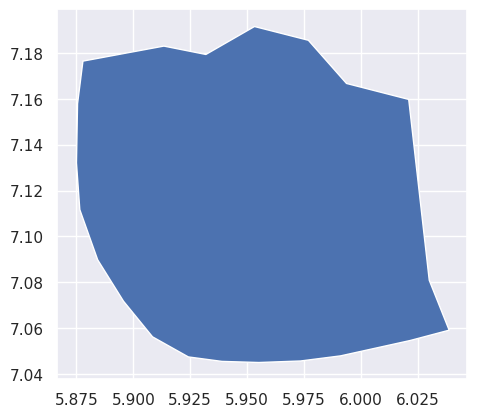

In [64]:
ethno.loc[ethno.ID==missing[0][:7]].plot()

In [67]:
A = ethno.loc[ethno.ID==missing[0][:7], 'geometry'].values[0]
B = ethno.loc[ethno.ID==missing[0][8:], 'geometry'].values[0]
print(A.intersects(B))
print(A.buffer(0.2).intersects(B))
A.buffer(0.2).intersection(B.boundary)

False
False


/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [68]:
ethno.loc[ethno.ID==missing[0][8:]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
6637,OKE-NGA,oke-NGA,oke-ng,oke-NI,Okpe,Okpe,OKPE,Okpe,Africa,Nigeria,25400,25400.0,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Nigeria,oke,6a,"POLYGON ((5.97268 5.41408, 5.93522 5.40111, 5...."


<AxesSubplot:>

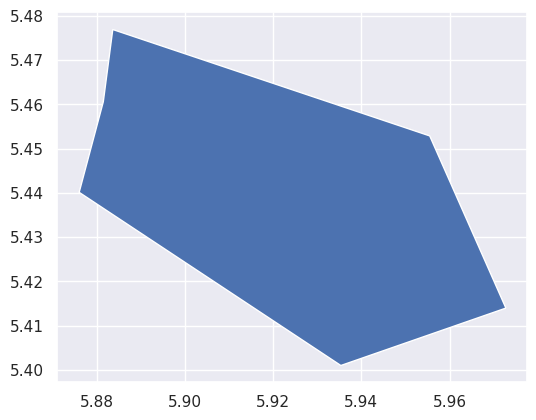

In [69]:
ethno.loc[ethno.ID==missing[0][8:]].plot()

<AxesSubplot:>

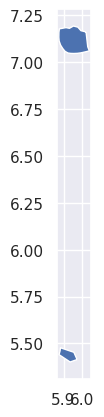

In [70]:
ethno.loc[(ethno.ID==missing[0][:7])|(ethno.ID==missing[0][8:])].plot()

In [71]:
pairs.loc[(pairs.ID_1==missing[0][:7])&(pairs.ID_2==missing[0][8:])]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2,ID,geometry_2


In [72]:
pairs.loc[(pairs.ID_2==missing[0][:7])&(pairs.ID_1==missing[0][8:])]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2,ID,geometry_2


In [73]:
missing[0][:7]

'AAA-NGA'

In [74]:
missing[0][8:]

'OKE-NGA'

These are missing because they are the same language but in two countries, or because the polygon is missing in v17 or as in example above in v17 they are not touching.

In [75]:
same_lang_miss = []
diff_lang_miss = []
for m in missing:
    if m[:3]==m[8:11]:
        same_lang_miss.append(m)
    else:
        diff_lang_miss.append(m)

In [76]:
len(diff_lang_miss)

1693

In [77]:
diff_lang_miss

['AAA-NGA-OKE-NGA',
 'AAL-NGA-KNC-NGA',
 'AAL-NGA-KOT-CMR',
 'AAL-NGA-SHU-CMR',
 'ABF-MYS-DBJ-MYS',
 'ABF-MYS-TSG-MYS',
 'ABQ-RUS-ADY-RUS',
 'ACC-GTM-QUC-GTM',
 'ACH-SDN-LOT-SDN',
 'ACH-SDN-MHI-SDN',
 'AEC-EGY-KZH-EGY',
 'AFB-YEM-AYH-YEM',
 'AFB-YEM-GDQ-YEM',
 'AGB-NGA-IZI-NGA',
 'AGB-NGA-ORG-NGA',
 'AGC-NGA-GBY-NGA',
 'AGH-COD-NGC-COD',
 'AGP-PHL-DGC-PHL',
 'AGP-PHL-DUO-PHL',
 'AGP-PHL-ILO-PHL',
 'AGZ-PHL-BHK-PHL',
 'AHK-THA-LIS-MMR',
 'AII-TUR-AYP-SYR',
 'AII-TUR-AYP-TUR',
 'AIM-IND-LIF-IND',
 'AIM-IND-LIF-NPL',
 'AIM-IND-NEP-IND',
 'AIM-IND-NMF-IND',
 'AJA-SDN-KRS-SDN',
 'AJA-SDN-YUL-SDN',
 'ALL-IND-KEJ-IND',
 'ALS-ALB-MKD-GRC',
 'ALY-AUS-ARE-AUS',
 'AMO-NGA-GNH-NGA',
 'AMQ-IDN-WEO-IDN',
 'AMT-PNG-SUG-PNG',
 'ANC-NGA-CLA-NGA',
 'ANC-NGA-KUL-NGA',
 'ANL-MMR-PRK-MMR',
 'ANL-MMR-SHN-MMR',
 'ANM-IND-MNI-MMR',
 'ANM-IND-ZOM-IND',
 'ANR-IND-LMN-IND',
 'ANR-IND-TEL-IND',
 'ANU-SDN-NUS-ETH',
 'ANU-SDN-NUS-SDN',
 'APC-LBN-ARS-SYR',
 'APH-NPL-MAI-NPL',
 'APH-NPL-MGP-NPL',
 'APL-USA-APM-USA',


In [78]:
ethno.loc[ethno.ID==m[:7]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
5007,ZUA-NGA,zua-NGA,zua-ng,zua-NI,Zeem,Zeem,ZEEM,Zeem,Africa,Nigeria,400,400.0,"Afro-Asiatic, Chadic, West, B, B.3, Zaar Proper",L,Afro-Asiatic,AFRO-ASIATIC,Nigeria,zua,7,"MULTIPOLYGON (((9.39765 10.08233, 9.38924 10.0..."


In [79]:
ethno.loc[ethno.ID==m[8:]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry


In [80]:
missing_lang = []
for m in missing:
    a = ethno.loc[ethno.ID==m[:7]]
    b = ethno.loc[ethno.ID==m[8:]]
    if a.shape[0]==0:
        missing_lang.append(m[:7])
    if b.shape[0]==0:
        missing_lang.append(m[8:])
missing_lang = list(set(missing_lang))
missing_lang

['MBF-SGP',
 'LDD-NGA',
 'ORN-MYS',
 'DWL-MLI',
 'BDJ-SDN',
 'SCA-MMR',
 'KPP-MMR',
 'MGX-PNG',
 'TVE-IDN',
 'OMG-BRA',
 'PNE-BRN',
 'DAF-CIV',
 'DEU-AUT',
 'NAE-IDN',
 'KZS-MYS',
 'BNB-MYS',
 'KLA-USA',
 'RWR-NPL',
 'TNI-IDN',
 'FGR-TCD',
 'TZB-MEX',
 'MVJ-MEX',
 'DTR-MYS',
 'PEQ-USA',
 'STC-SLB',
 'TZZ-MEX',
 'CCQ-MMR',
 'DKS-SDN',
 'WIW-AUS',
 'HTI-IDN',
 'SAP-PRY',
 'NZU-COG',
 'CKF-GTM',
 'BFY-NPL',
 'TZU-MEX',
 'SER-USA',
 'QUI-USA',
 'HPO-MMR',
 'OMG-PER',
 'COD-BRA',
 'BDH-SDN',
 'BNC-PHL',
 'DRW-AFG',
 'CKK-GTM',
 'KZH-EGY',
 'MWD-AUS',
 'KUR-TKM',
 'NDO-AGO',
 'VLR-VUT',
 'MEG-NCL',
 'MES-TCD',
 'BDG-MYS',
 'MTZ-GTM',
 'BOD-BTN',
 'MTZ-MEX',
 'LMM-KHM',
 'TEX-SDN',
 'BZI-THA',
 'GAV-PNG',
 'PNV-AUS',
 'YEN-NGA',
 'SRK-MYS',
 'NHF-AUS',
 'MNQ-MYS',
 'ORI-IND',
 'PCK-MMR',
 'PKN-AUS',
 'TSK-NPL',
 'BLM-SDN',
 'TSK-BTN',
 'IXI-GTM',
 'SUM-NIC',
 'TFR-CRI',
 'CRQ-BOL',
 'RIL-MMR',
 'DID-SDN',
 'NNX-CMR',
 'AFB-YEM',
 'WBA-GUY',
 'KZH-SDN',
 'TZT-GTM',
 'ASB-USA',
 'ANU-SDN',
 'KG

Lots of languages disappeared from v17 that may have been there in v16 they seem to be extinct.

Let's find which languages in the replication file are not in v17 (let's also compare v16 vs v17 directly)

In [81]:
ethno.shape

(7387, 20)

In [82]:
ethno16 = gp.read_file(pathethno.replace('v17', 'v16') + 'langa.shp')
ethno16.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,"116,000,000 in Russian Federation (2002 census)",116000000,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,"215,000,000 in United States (2000 census)",215000000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,"MULTIPOLYGON (((-75.11965 19.97388, -75.11741 ..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,"163,000,000 in Brazil (1998)",163000000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,"17,400,000 in Australia (2006)",17400000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,"MULTIPOLYGON (((147.36099 -43.08758, 147.36375..."
4,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [83]:
ethno_ID = set(ethno.ID)
ethno16_ID = set(ethno16.ID)

In [84]:
new_langs = len(ethno_ID.difference(ethno16_ID))
new_langs

414

In [85]:
lost_langs = len(ethno16_ID.difference(ethno_ID))
lost_langs

537

In [86]:
new_langs + lost_langs

951

In [87]:
len(missing_lang)

379

In [88]:
set(missing_lang).difference(ethno16_ID.difference(ethno_ID))

set()

<AxesSubplot:>

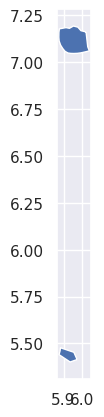

In [90]:
ethno.loc[(ethno.ID==missing[0][:7])|(ethno.ID==missing[0][8:])].plot()

<AxesSubplot:>

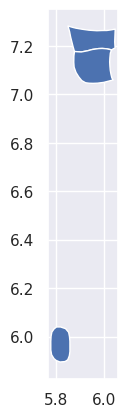

In [89]:
ethno16.loc[(ethno16.ID==missing[0][:7])|(ethno16.ID==missing[0][8:])].plot()

So all missing languages are due to difference between v16 and 17

We have (essencially) replicated his data

# New Data - Buffers

In [91]:
buffers= borders_geo[['identifier', 'border']].merge(merge_iden[['identifier']])
buffers

,identifier,border
0,KHK-MNG-CMN-CHN,"LINESTRING (96.29691 42.52898, 96.30858 42.544..."
1,KHG-CHN-CMN-CHN,"LINESTRING (102.24263 29.72548, 102.20450 29.7..."
2,ADX-CHN-CMN-CHN,"MULTILINESTRING ((103.34328 32.41462, 103.3294..."
3,XAL-CHN-CMN-CHN,"MULTILINESTRING ((101.03075 36.42174, 101.0269..."
4,KAZ-CHN-CMN-CHN,"MULTILINESTRING ((85.79039 43.12162, 85.78670 ..."
...,...,...
13820,MUC-CMR-BOE-CMR,"LINESTRING (10.27755 6.54777, 10.27743 6.54410..."
13821,TQL-VUT-URR-VUT,"LINESTRING (167.36785 -13.52711, 167.36645 -13..."
13822,BDX-IDN-TOY-IDN,"LINESTRING (119.31693 -2.07812, 119.30790 -2.0..."
13823,TUC-PNG-BBV-PNG,"LINESTRING (147.83801 -5.67779, 147.83871 -5.6..."


In [92]:
buffers.to_file(pathout + 'Dickens_ethnologue_bordersv17.json', driver="GeoJSON")

We convert to CEA to construct the buffers and create the data

In [93]:
buffers = buffers.to_crs(cea)

In [94]:
buffers.to_file(pathout + 'Dickens_ethnologue_bordersv17_cyl.json', driver="GeoJSON")

In [6]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_bordersv17_cyl.json', driver="GeoJSON")

In [95]:
buffers = dask_geopandas.from_geopandas(buffers, npartitions=10)

In [96]:
buffers.geometry = buffers.geometry.buffer(50000)
buffers = buffers.compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 17.45 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [98]:
buffers.to_file(pathout + 'Dickens_ethnologue_buffersv17_cyl.json', driver="GeoJSON")

In [99]:
buffers = buffers.to_crs(wgs84)

In [100]:
buffers.to_file(pathout + 'Dickens_ethnologue_buffersv17.json', driver="GeoJSON")

/tmp/ipykernel_3341423/2640991670.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers.centroid.plot()


<AxesSubplot:>

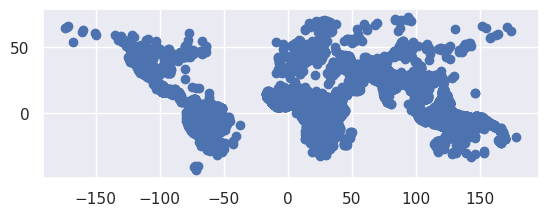

In [101]:
buffers.centroid.plot()

In [102]:
type(buffers)

geopandas.geodataframe.GeoDataFrame

# New Data - Spatial Stats for New Buffers

In [105]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_buffersv17.json', driver="GeoJSON")
buffers.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [107]:
buffers.loc[buffers.is_valid==False]

,identifier,geometry
104,KLD-AUS-ENG-AUS,None
183,MYI-IND-HIN-IND,None
184,MUP-IND-HIN-IND,None
581,BGC-IND-HIN-IND,None
582,BHO-IND-HIN-IND,None
583,HOJ-IND-HIN-IND,None
585,BRA-IND-HIN-IND,None
587,SCK-IND-HIN-IND,None
1278,BJJ-IND-HIN-IND,None
1279,GNO-IND-HIN-IND,None


In [110]:
buffers = buffers.loc[buffers.geometry!=None].reset_index(drop=True)

Work with CSI data to compute spatial statistics

In [103]:
CSI = os.listdir(proot + 'CSI')

In [104]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [111]:
%%time
for r in CSI:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSI/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[1:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier'] + [r.replace('.tif', '') + c for c in out.columns[1:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '.dta', version=117, write_index=False)    

dif2AverageCalories
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
dif2AverageCalories0
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
dif2AverageCaloriesNo0
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
dif2OptCalories
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
dif2OptCalories0
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
dif2OptCaloriesNo0
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
difAverageCalories
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
difAverageCalories0
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
difAverageCaloriesNo0
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
difOptCalories
Index(['identifier', 'min', 'mean', 'median', 'max', 'std'], dtype='object')
difOptCalories0
Index(['identifier', '

In [112]:
%%time
out = []
for r in CSI:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '.dta')   
    out1 = out1.set_index(['identifier'])
    out.append(out1)

dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCaloriesNo0
pre15002AverageCalories
pre15002AverageCalories0
pre15002AverageCaloriesNo0
pre15002OptCalories
pre15002OptCalories0
pre15002OptCaloriesNo0
pre1500AverageCalories
pre1500AverageCalories0
pre1500AverageCaloriesNo0
pre1500OptCalories
pre1500OptCalories0
pre1500OptCaloriesNo0
CPU times: user 1.54 s, sys: 380 ms, total: 1.92 s
Wall time: 1.83 s


In [113]:
out = pd.concat(out, axis=1)

In [114]:
out.to_stata(proot + 'Dickens_OrBuf_v17_stats.dta', version=117)